In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit

In [ ]:
# 1. Define your desired accents
ACCENTS_TO_KEEP = ['India and South Asia (India, Pakistan, Sri Lanka)',
                   'Australian English',
                   'Southern African (South Africa, Zimbabwe, Namibia)',
                   'Singaporean English']

# 2. Load the metadata file
df = pd.read_csv('cv-corpus-23.0-2025-09-05/en/validated.tsv', sep='\t')

# 3. Filter for the desired accents
filtered_df = df[df['accents'].isin(ACCENTS_TO_KEEP)]

# 4. Extract the relative file paths
file_paths_to_extract = filtered_df['path'].tolist()

# 5. Save the list of required files to a plain text file
output_file = 'required_files.txt'
with open(output_file, 'w') as f:
    for path in file_paths_to_extract:
        f.write(path + '\n') 

print(f"Successfully generated a list of {len(file_paths_to_extract)} files in '{output_file}'.")

/tmp/ipykernel_996884/18608975.py:9: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cv-corpus-23.0-2025-09-05/en/validated.tsv', sep='\t')


Successfully generated a list of 195128 files in 'required_files.txt'.


In [95]:
filter_df = df[df['accents'].isin(ACCENTS_TO_KEEP)]
np.unique_counts(filter_df['accents'])

UniqueCountsResult(values=array(['Australian English',
       'India and South Asia (India, Pakistan, Sri Lanka)',
       'Singaporean English',
       'Southern African (South Africa, Zimbabwe, Namibia)'], dtype=object), counts=array([ 55328, 109625,   3620,  26555]))

In [96]:
clip_duration = pd.read_csv('cv-corpus-23.0-2025-09-05/en/clip_durations.tsv', sep='\t')
merged_df = pd.merge(filtered_df, clip_duration, on='path', how='left')

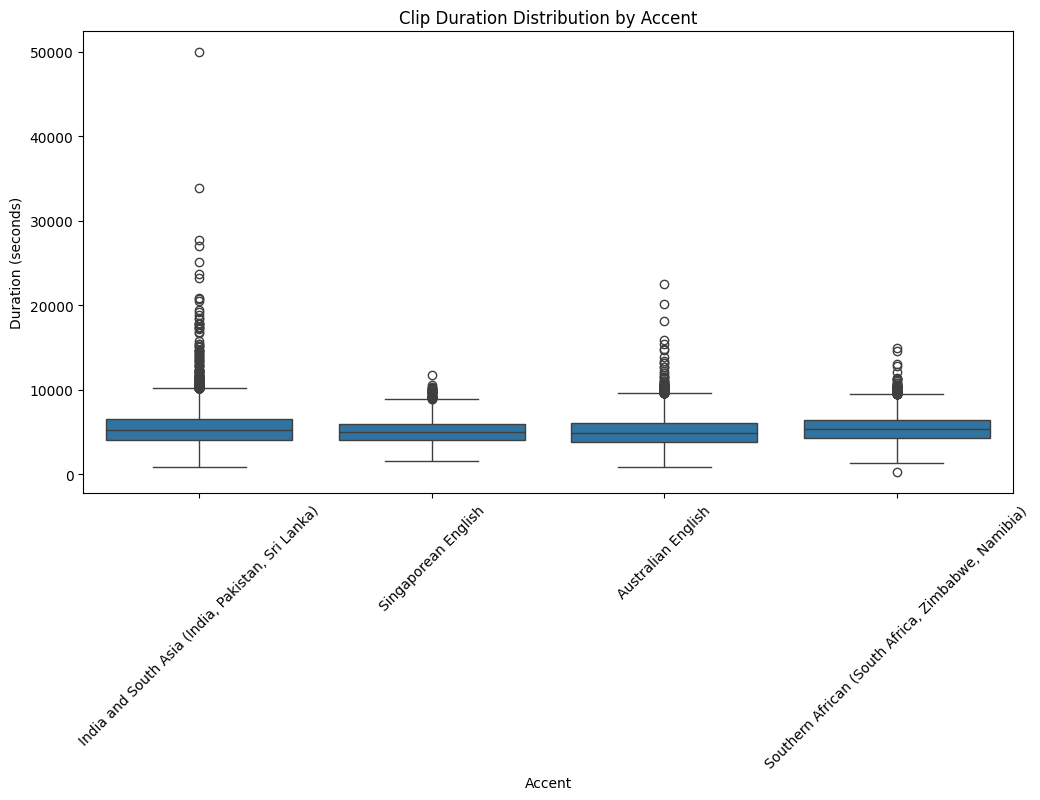

In [98]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='accents', y='duration[ms]', data=merged_df)
plt.xticks(rotation=45)
plt.title('Clip Duration Distribution by Accent')
plt.xlabel('Accent')
plt.ylabel('Duration (seconds)')
plt.show()

In [101]:
merged_df.groupby('accents')['duration[ms]'].agg(['mean', 'median', 'min'])

,mean,median,min
accents,,,
Australian English,5031.372921,4932.0,864
"India and South Asia (India, Pakistan, Sri Lanka)",5357.300214,5256.0,936
Singaporean English,5044.322652,4968.0,1560
"Southern African (South Africa, Zimbabwe, Namibia)",5417.020072,5376.0,252


### Split Train & Test

In [118]:
# group shuffle split to avoid same user in train and test
gss = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=42)

train_idx, test_idx = next(gss.split(merged_df, groups=merged_df['client_id']))
train_df = merged_df.iloc[train_idx]
test_df = merged_df.iloc[test_idx]
user_ids = merged_df['client_id'].unique()

In [119]:
# print shapes and unique users
print(f"Train shape: {train_df.shape}, Unique users in train: {train_df['client_id'].nunique()}")
print(np.unique_counts(train_df['accents']))
print()
print(f"Test shape: {test_df.shape}, Unique users in test: {test_df['client_id'].nunique()}")
print(np.unique_counts(test_df['accents']))
print()
print(f"Total unique users: {len(user_ids)}")                    

Train shape: (171805, 14), Unique users in train: 3274
UniqueCountsResult(values=array(['Australian English',
       'India and South Asia (India, Pakistan, Sri Lanka)',
       'Singaporean English',
       'Southern African (South Africa, Zimbabwe, Namibia)'], dtype=object), counts=array([52602, 91598,  3454, 24151]))

Test shape: (23323, 14), Unique users in test: 364
UniqueCountsResult(values=array(['Australian English',
       'India and South Asia (India, Pakistan, Sri Lanka)',
       'Singaporean English',
       'Southern African (South Africa, Zimbabwe, Namibia)'], dtype=object), counts=array([ 2726, 18027,   166,  2404]))

Total unique users: 3638


### Outlier Removal

In [120]:
# remove outliers based on duration
def remove_outliers(df):
    def filter_outliers(group):
        Q1 = group['duration[ms]'].quantile(0.25)
        Q3 = group['duration[ms]'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return group[(group['duration[ms]'] >= lower_bound) & (group['duration[ms]'] <= upper_bound)]
    
    return df.groupby('accents').apply(filter_outliers).reset_index(drop=True)

In [121]:
cleaned_train = remove_outliers(train_df)
cleaned_test = remove_outliers(test_df)

/tmp/ipykernel_996884/3670618187.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('accents').apply(filter_outliers).reset_index(drop=True)
/tmp/ipykernel_996884/3670618187.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('accents').apply(filter_outliers).reset_index(drop=True)


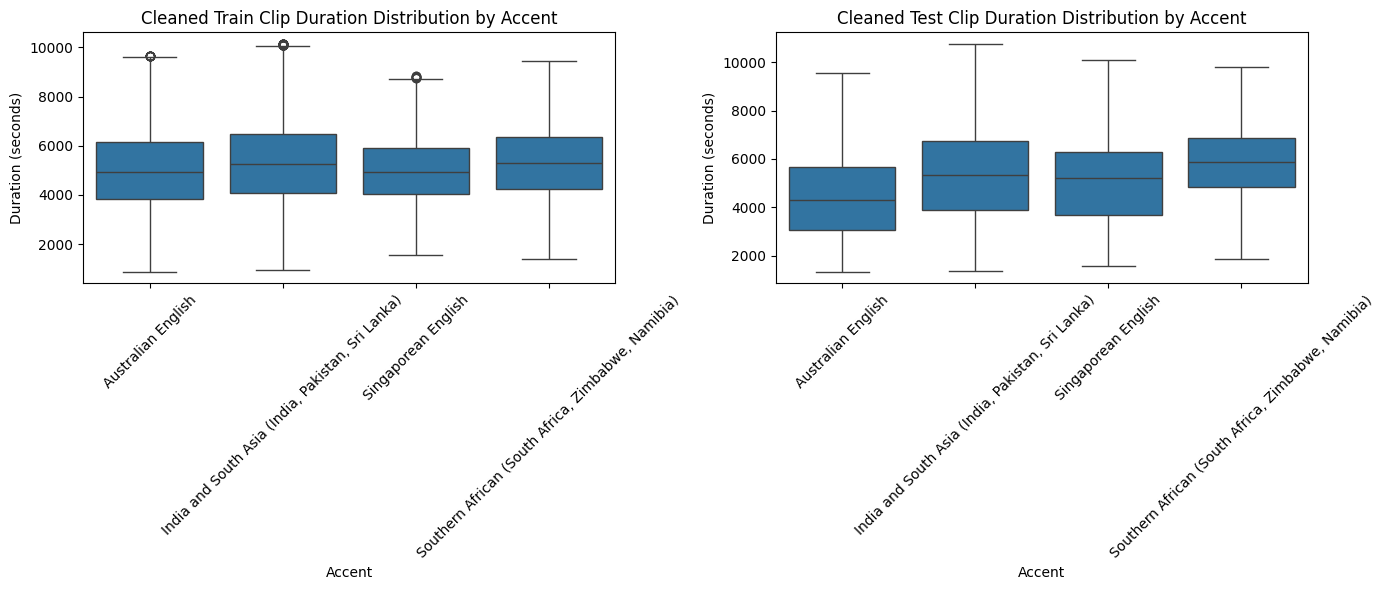

In [128]:
# sub plot of both boxplots of cleaned train and test
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='accents', y='duration[ms]', data=cleaned_train)
plt.xticks(rotation=45)
plt.title('Cleaned Train Clip Duration Distribution by Accent')
plt.xlabel('Accent')
plt.ylabel('Duration (seconds)')
plt.subplot(1, 2, 2)
sns.boxplot(x='accents', y='duration[ms]', data=cleaned_test)
plt.xticks(rotation=45)
plt.title('Cleaned Test Clip Duration Distribution by Accent')
plt.xlabel('Accent')
plt.ylabel('Duration (seconds)')
plt.tight_layout()
plt.show()

### Final Sampling at Random

In [142]:
# Train Set -> 2000/2000/2000/2000
final_train = []
for accent in ACCENTS_TO_KEEP:
    accent_df = cleaned_train[cleaned_train['accents'] == accent]

    if len(accent_df) < 2000:
        final_train = accent_df
    else:
        sampled_accent_df = accent_df.sample(n=2000, random_state=42)
    final_train.append(sampled_accent_df)
final_train = pd.concat(final_train)


# TEST Set -> 100/100/100/100
final_test = []
for accent in ACCENTS_TO_KEEP:
    accent_df = cleaned_test[cleaned_test['accents'] == accent]
    if len(accent_df) < 100:
        final_test = accent_df
    else:
        sampled_accent_df = accent_df.sample(n=100, random_state=42)
    final_test.append(sampled_accent_df)
final_test = pd.concat(final_test)

In [144]:
print(np.unique_counts(final_train['accents']))
print()
print(np.unique_counts(final_test['accents']))

UniqueCountsResult(values=array(['Australian English',
       'India and South Asia (India, Pakistan, Sri Lanka)',
       'Singaporean English',
       'Southern African (South Africa, Zimbabwe, Namibia)'], dtype=object), counts=array([2000, 2000, 2000, 2000]))

UniqueCountsResult(values=array(['Australian English',
       'India and South Asia (India, Pakistan, Sri Lanka)',
       'Singaporean English',
       'Southern African (South Africa, Zimbabwe, Namibia)'], dtype=object), counts=array([100, 100, 100, 100]))


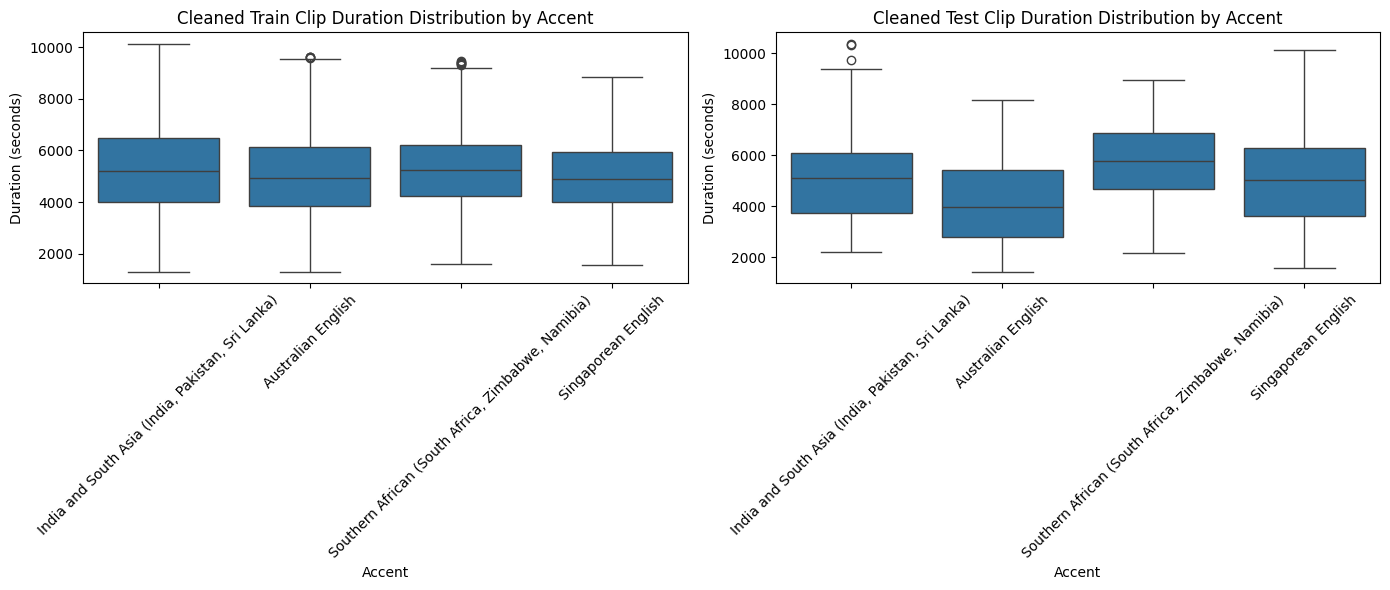

In [146]:
# sub plot of both boxplots of cleaned train and test
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='accents', y='duration[ms]', data=final_train)
plt.xticks(rotation=45)
plt.title('Cleaned Train Clip Duration Distribution by Accent')
plt.xlabel('Accent')
plt.ylabel('Duration (seconds)')
plt.subplot(1, 2, 2)
sns.boxplot(x='accents', y='duration[ms]', data=final_test)
plt.xticks(rotation=45)
plt.title('Cleaned Test Clip Duration Distribution by Accent')
plt.xlabel('Accent')
plt.ylabel('Duration (seconds)')
plt.tight_layout()
plt.show()

### Export required files for extraction

In [151]:
# save final train and test to csv
final_train.to_csv('final_train.csv', index=False)
final_test.to_csv('final_test.csv', index=False)

# Export required files for extraction
train_file = 'train_files.txt'
with open(train_file, 'w') as f:
    for path in final_train['path'].tolist():
        path = 'cv-corpus-23.0-2025-09-05/en/clips/' + path
        f.write(path + '\n')
    print(f"Successfully generated a list of {len(final_train)} training files in '{train_file}'.")

test_file = 'test_files.txt'
with open(test_file, 'w') as f:
    for path in final_test['path'].tolist():
        path = 'cv-corpus-23.0-2025-09-05/en/clips/' + path
        f.write(path + '\n')
    print(f"Successfully generated a list of {len(final_test)} testing files in '{test_file}'.")

Successfully generated a list of 8000 training files in 'train_files.txt'.
Successfully generated a list of 400 testing files in 'test_files.txt'.
